In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from material_models import Fung, GOH, MR, HGO
from NODE_fns import NODE_sigma_vmap
import pickle

In [2]:
def matrix_from_stretch(lm1, lm2, lm3): #Function to turn lm to F and C
    zeros = np.zeros(lm1.shape)
    F = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))
    C = np.einsum('...ij,...jk->...ik', F, F.transpose(0,2,1))
    return F, C

In [3]:
#Load the NN parameters
with open('savednet/P12AC1_bsxsy.npy', 'rb') as f:
    NODE_params = pickle.load(f)
theta = NODE_params[-1]

In [4]:
#Load and prepare all of the experimental data
dataset_name = 'P12AC1_xybsxsy'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_exp, sig_gt = np.load(f,allow_pickle=True)
ndata = lm_exp.shape[0]

lm3_exp = 1/(lm_exp[:,0]*lm_exp[:,1])
F_exp, C_exp = matrix_from_stretch(lm_exp[:,0], lm_exp[:,1], lm3_exp)
F_inv = np.linalg.inv(F_exp)
F_inv_T = np.linalg.inv(np.transpose(F_exp,[0,2,1]))

sig_exp = np.zeros((ndata,3,3))
sig_exp[:,0,0] = sig_gt[:,0]
sig_exp[:,1,1] = sig_gt[:,1]
sigma_mp = np.max(sig_exp, axis=(1,2))

In [5]:
#Fitting parameters for P12AC1 on Equibiaxial + StripX + StripY data
GOH_params = [1.00000000e-02, 9.32867749e+00, 6.56596186e+01, 3.00449522e-01, 1.58882553e+00]
MR_params  = [0.        , 0.06869736, 0.38512913]
HGO_params = [0.10490629,  0.04900617, 32.26986427,  1.10324263]
Fung_params= [0.03045098, 10.04318653, 10.        , 20.42962312]

In [6]:
lm1 = np.linspace(1,1.22,50)
lm2 = np.linspace(1,1.18,50)
lm1, lm2 = np.meshgrid(lm1, lm2)
lm3 = 1/(lm1*lm2)
lm = np.array([lm1.flatten(), lm2.flatten()]).T

F = np.zeros((lm.shape[0], 3, 3))
F[:,0,0] = lm[:,0]
F[:,1,1] = lm[:,1]
F[:,2,2] = 1/(lm[:,0]*lm[:,1])
sigma_surf_NN = NODE_sigma_vmap(F, NODE_params).reshape(50,50,3,3)
GOH_MM = GOH(GOH_params)
MR_MM = MR(MR_params)
HGO_MM = HGO(HGO_params)
Fung_MM = Fung(Fung_params)
sigma_surf_GOH  = GOH_MM.sigma(lm).reshape(50,50,3,3)
sigma_surf_MR   = MR_MM.sigma(lm).reshape(50,50,3,3)
sigma_surf_HGO  = HGO_MM.sigma(lm).reshape(50,50,3,3)
sigma_surf_Fung = Fung_MM.sigma(lm).reshape(50,50,3,3)

sigma_mp_surf_NN   = np.max(sigma_surf_NN, axis=(2,3))
sigma_mp_surf_GOH  = np.max(sigma_surf_GOH, axis=(2,3))
sigma_mp_surf_MR   = np.max(sigma_surf_MR, axis=(2,3))
sigma_mp_surf_HGO  = np.max(sigma_surf_HGO, axis=(2,3))
sigma_mp_surf_Fung = np.max(sigma_surf_Fung, axis=(2,3))

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)
sigma_GOH  = GOH_MM.sigma(lm_exp)
sigma_MR   = MR_MM.sigma(lm_exp)
sigma_HGO  = HGO_MM.sigma(lm_exp)
sigma_Fung = Fung_MM.sigma(lm_exp)

In [8]:
def error(sigma_pred):
    sigma_mp_pred = np.max(sigma_pred, axis=(1,2))
    E_total = np.abs(sigma_mp_pred-sigma_mp)
    E_train = np.mean(E_total[148:])
    E_valid = np.mean(E_total[:148])
    return E_total, E_train, E_valid

GOH_e,  GOH_t_e,  GOH_v_e = error(sigma_GOH)
MR_e,   MR_t_e,   MR_v_e = error(sigma_MR)
HGO_e,  HGO_t_e,  HGO_v_e = error(sigma_HGO)
Fung_e, Fung_t_e, Fung_v_e = error(sigma_Fung)
NN_e,   NN_t_e,   NN_v_e = error(sigma_NN)

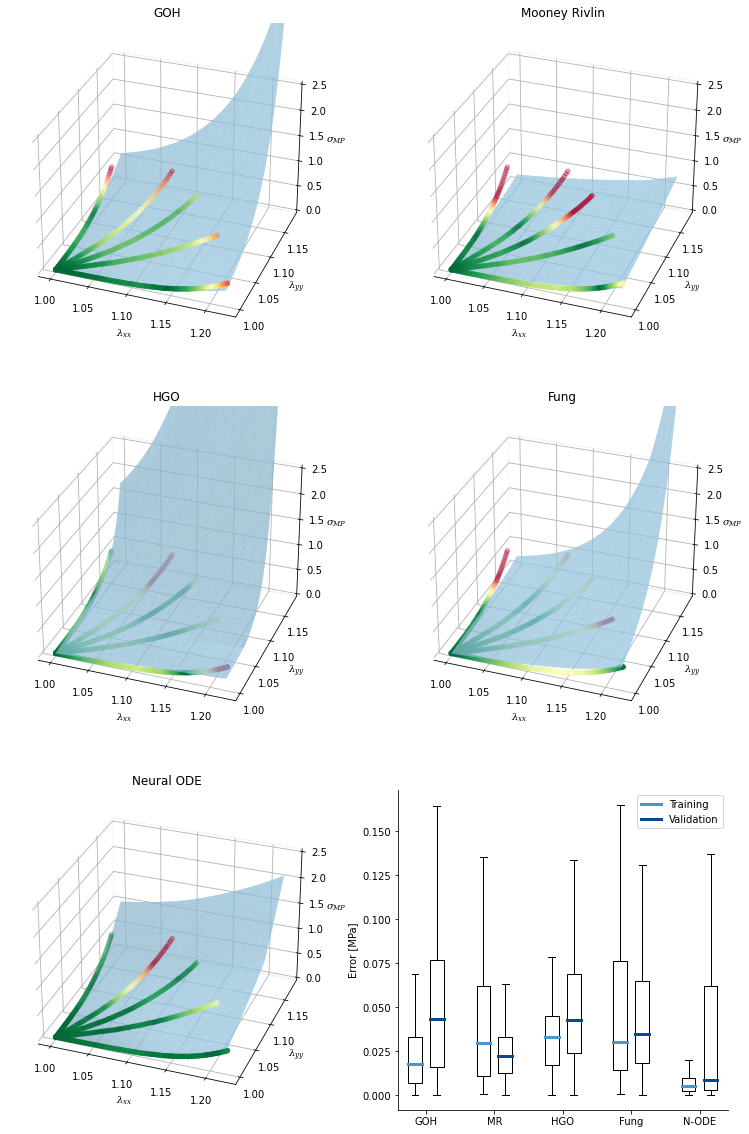

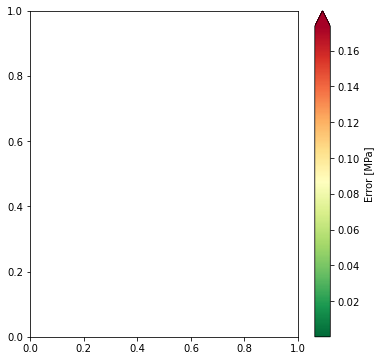

In [13]:
def commonformat(ax1, title):
    ax1.set(xlabel = '$\lambda_{xx}$', ylabel ='$\lambda_{yy}$', zlabel = '$\sigma_{MP}$', title = title, zlim=(0,2.5), yticks=yticks)
    ax1.azim = -70
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.set_rotate_label(False)
    ax1.yaxis.set_rotate_label(False)
    ax1.zaxis.set_rotate_label(False)
    
blue = cm.Blues(np.ones_like(sigma_mp_surf_GOH)*0.4)
col = cm.get_cmap('RdYlGn_r')
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams.update({'font.sans-serif':'Arial'})
vmin = np.min(NN_e)
vmax = np.max(NN_e)*0.5
yticks = [1, 1.05, 1.1, 1.15]

fig = plt.figure(figsize = (13,20))
ax1 = fig.add_subplot(321, projection = '3d')
surf = ax1.plot_surface(lm1, lm2, sigma_mp_surf_GOH, facecolors=blue, rcount = 20, ccount = 20, linewidth=0.2, alpha=0.7)
ax1.scatter(lm_exp[:,0], lm_exp[:,1], sigma_mp, c=GOH_e, cmap=col, vmin=vmin, vmax=vmax)
commonformat(ax1, 'GOH')

ax2 = fig.add_subplot(322, projection = '3d')
col2 = cm.RdYlGn_r(MR_e*5)
surf = ax2.plot_surface(lm1, lm2, sigma_mp_surf_MR, facecolors=blue, rcount = 20, ccount = 20, linewidth=0.2, alpha=0.7)
ax2.scatter(lm_exp[:,0], lm_exp[:,1], sigma_mp, c=MR_e, cmap=col, vmin=vmin, vmax=vmax)
commonformat(ax2, 'Mooney Rivlin')

ax3 = fig.add_subplot(323, projection = '3d')
col2 = cm.RdYlGn_r(HGO_e*5)
surf = ax3.plot_surface(lm1, lm2, sigma_mp_surf_HGO, facecolors=blue, rcount = 20, ccount = 20, linewidth=0.2, alpha=0.7)
ax3.scatter(lm_exp[:,0], lm_exp[:,1], sigma_mp, c=HGO_e, cmap=col, vmin=vmin, vmax=vmax)
commonformat(ax3, 'HGO')

ax4 = fig.add_subplot(324, projection = '3d')
col2 = cm.RdYlGn_r(Fung_e*5)
surf = ax4.plot_surface(lm1, lm2, sigma_mp_surf_Fung, facecolors=blue, rcount = 20, ccount = 20, linewidth=0.2, alpha=0.7)
ax4.scatter(lm_exp[:,0], lm_exp[:,1], sigma_mp, c=Fung_e, cmap=col, vmin=vmin, vmax=vmax)
commonformat(ax4, 'Fung')

ax5 = fig.add_subplot(325, projection = '3d')
col2 = cm.RdYlGn_r(NN_e*5)
col2 = cm.get_cmap('RdYlGn_r')
surf = ax5.plot_surface(lm1, lm2, sigma_mp_surf_NN, facecolors=blue, rcount = 20, ccount = 20, linewidth=0.2, alpha=0.7)
sctr = ax5.scatter(lm_exp[:,0], lm_exp[:,1], sigma_mp, c=NN_e, cmap = col, vmin=vmin, vmax=vmax)
commonformat(ax5, 'Neural ODE')

ax6 = fig.add_subplot(326)
labels = ['GOH', 'MR', 'HGO', 'Fung', 'N-ODE']
x = np.arange(0,10,2)
w = 0.4
bp1 = ax6.boxplot([GOH_e[148:], MR_e[148:], HGO_e[148:], Fung_e[148:], NN_e[148:]], positions = x-w*0.8, widths=w, labels= labels,
            medianprops={'color':cm.Blues(0.6), 'linewidth':3}, showfliers=False)
bp2 = ax6.boxplot([GOH_e[:148], MR_e[:148], HGO_e[:148], Fung_e[:148], NN_e[:148]], positions = x+w*0.8, widths=w,
            medianprops={'color':cm.Blues(0.9), 'linewidth':3}, showfliers=False)
ax6.set_ylabel('Error [MPa]')
ax6.set_xticks(x)
# ax6.set_xticklabels(labels)
ax6.legend([bp1['medians'][0],bp2['medians'][0]], ['Training', 'Validation'])
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

fig.savefig('Figures/rfig_exp2.jpg', dpi=400, bbox_inches='tight')

fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot()
fig2.colorbar(sctr, ax=ax, label = 'Error [MPa]', extend='max')
fig2.savefig('Figures/rfig_exp2_colorbar.jpg', dpi=400, bbox_inches='tight')
pass